In [3]:
import os
import cv2
import uuid
import time

In [4]:
uuid.uuid1()

UUID('78d55565-10ce-11ee-b984-30c9abd590fa')

In [5]:
IMAGE_PATH = os.path.join('data', 'images')
number_images = 30

In [12]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
  print('Collecting images {}'.format(imgnum))
  ret, frame = cap.read()
  imgname = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
  cv2.imwrite(imgname, frame)
  cv2.imshow('frame', frame)
  time.sleep(0.5)

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

In [16]:
!labelme

External WM_DESTROY received for  QWidgetWindow(0x1f1063c9600, name="FilesWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x1f105dfde60, name="MainWindowClassWindow")
External WM_DESTROY received for  QWidgetWindow(0x1f1064a24d0, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x1f105dfde60, name="MainWindowClassWindow")


### Reviewing Dataset and Building Image Loading Function

In [17]:
import tensorflow as tf
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
tf.config.list_physical_devices('GPU')

[]

In [55]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [56]:
images.as_numpy_iterator().next()

b'data\\images\\6db2791c-103a-11ee-a130-30c9abd590fa.jpg'

In [57]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [58]:
images = images.map(load_image)

In [59]:
images.as_numpy_iterator().next()

array([[[221, 236, 233],
        [220, 235, 232],
        [220, 235, 232],
        ...,
        [120, 112,  93],
        [118, 110,  91],
        [110, 102,  83]],

       [[221, 236, 233],
        [220, 235, 232],
        [220, 235, 232],
        ...,
        [124, 115,  98],
        [117, 108,  91],
        [112, 103,  86]],

       [[221, 236, 233],
        [220, 235, 232],
        [220, 235, 232],
        ...,
        [128, 116, 102],
        [118, 106,  92],
        [115, 103,  89]],

       ...,

       [[175, 194, 201],
        [175, 194, 201],
        [175, 194, 201],
        ...,
        [157, 160, 153],
        [158, 160, 155],
        [161, 163, 158]],

       [[175, 194, 201],
        [175, 194, 201],
        [175, 194, 201],
        ...,
        [155, 158, 151],
        [157, 159, 154],
        [161, 163, 158]],

       [[175, 194, 201],
        [175, 194, 201],
        [175, 194, 201],
        ...,
        [154, 157, 150],
        [156, 158, 153],
        [161, 163, 158]]

In [60]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [61]:
image_generator = images.batch(4).as_numpy_iterator()

In [72]:
plot_images = image_generator.next()

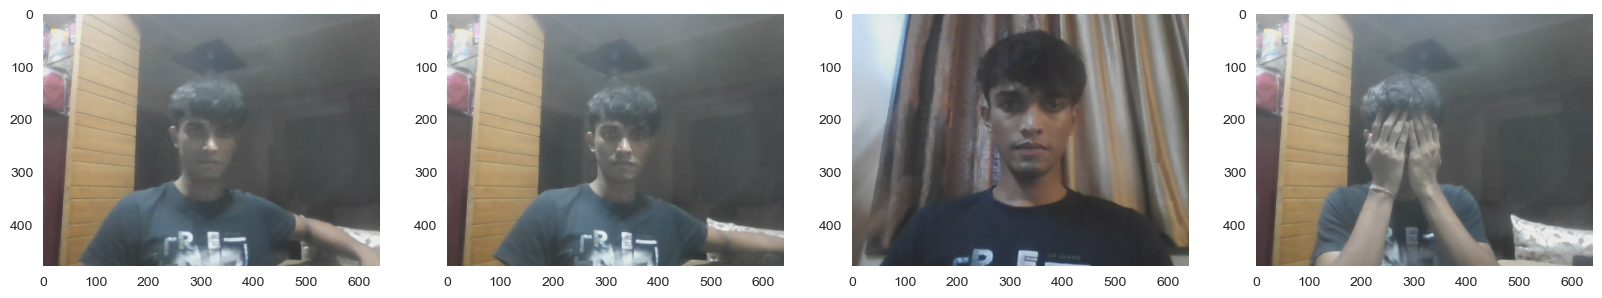

In [73]:
fig , ax = plt.subplots(ncols =4, figsize = (20,20))
for idx , image in enumerate(plot_images):
    ax[idx].imshow(image)
    ax[idx].grid(False)
plt.show()

In [78]:
#Moving labels according to the image locations
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data',folder, 'images')):
        
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

### Applying Image Augmentations on Images and Labels using Albumentation

In [86]:
import albumentations as alb

In [94]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height = 450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params = alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [95]:
img = cv2.imread(os.path.join('data', 'train','images','1a583291-103a-11ee-b7e6-30c9abd590fa.jpg'))

In [99]:
with open(os.path.join('data','train','labels', '1a583291-103a-11ee-b7e6-30c9abd590fa.json'), 'r') as f:
    label = json.load(f)

In [103]:
label['shapes'][0]['points']

[[291.95121951219517, 80.2439024390244], [533.4146341463415, 338.780487804878]]

In [106]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [108]:
coords

[291.95121951219517, 80.2439024390244, 533.4146341463415, 338.780487804878]

In [109]:
coords = list(np.divide(coords,[640,480,640,480]))

In [110]:
coords

[0.45617378048780494,
 0.16717479674796748,
 0.8334603658536587,
 0.7057926829268292]

In [111]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [112]:
augmented

{'image': array([[[237, 235, 235],
         [237, 235, 235],
         [237, 235, 235],
         ...,
         [191, 191, 191],
         [185, 185, 185],
         [179, 179, 179]],
 
        [[237, 235, 235],
         [237, 235, 235],
         [237, 235, 235],
         ...,
         [186, 186, 186],
         [188, 188, 188],
         [180, 180, 180]],
 
        [[237, 235, 235],
         [237, 235, 235],
         [237, 235, 235],
         ...,
         [189, 189, 189],
         [192, 192, 192],
         [181, 181, 181]],
 
        ...,
 
        [[120, 122, 123],
         [119, 121, 122],
         [120, 121, 125],
         ...,
         [ 66,  55,  47],
         [ 64,  55,  46],
         [ 64,  55,  46]],
 
        [[120, 122, 123],
         [120, 122, 123],
         [121, 122, 126],
         ...,
         [ 66,  55,  47],
         [ 65,  56,  47],
         [ 65,  56,  47]],
 
        [[120, 122, 123],
         [120, 122, 123],
         [121, 123, 124],
         ...,
         [ 65,  56,

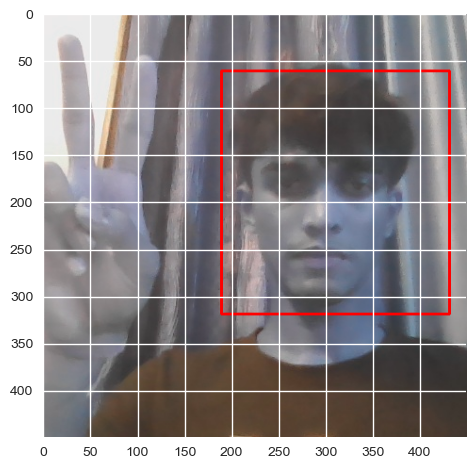

In [114]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
             (255,0,0),2)
plt.imshow(augmented['image'])

### Running and Building Augmentation Pipeline

In [117]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8334603658536587, 0.660060975609756, 0.5895579268292683, 0.146849593495935, 'face'].
x_max is less than or equal to x_min for bbox [0.7115091463414634, 0.5940040650406504, 0.28504468938920163, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.1932164634146342, 0.7210365853658537, 0.010289634146341528, 0.2433943089430894, 'face'].
x_max is less than or equal to x_min for bbox [0.654344512195122, 0.6702235772357722, 0.341844512195122, 0.10111788617886183, 'face'].
x_max is less than or equal to x_min for bbox [0.1894054878048781, 0.8887195121951218, 0.0064786585365854315, 0.30945121951219506, 'face'].
x_max is less than or equal to x_min for bbox [0.6467225609756098, 0.6956300813008129, 0.4104420731707317, 0.2586382113821138, 'face'].
x_max is less than or equal to x_min for bbox [0.5743140243902439, 0.9496951219512195, 0.09794207317073175, 0.0604674796747967, 'face'].
x_max is less than or equal to x_min for bbox [0.673399390

In [118]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [119]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [120]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [121]:
train_images.as_numpy_iterator().next()

array([[[0.2769608 , 0.18731618, 0.2322304 ],
        [0.2748162 , 0.18235295, 0.2341299 ],
        [0.26979166, 0.16832107, 0.22567402],
        ...,
        [0.2367647 , 0.11519608, 0.13872549],
        [0.24295343, 0.11764706, 0.13743873],
        [0.24313726, 0.11764706, 0.13725491]],

       [[0.2720588 , 0.2036152 , 0.2463848 ],
        [0.26617646, 0.1877451 , 0.23480392],
        [0.2641544 , 0.1778799 , 0.22886029],
        ...,
        [0.23915441, 0.11758579, 0.1411152 ],
        [0.23529412, 0.11372549, 0.13725491],
        [0.23805147, 0.11519608, 0.13743873]],

       [[0.28970587, 0.20882353, 0.2632353 ],
        [0.2740196 , 0.1877451 , 0.23872548],
        [0.27757353, 0.18345588, 0.23835784],
        ...,
        [0.23921569, 0.11764706, 0.14117648],
        [0.23921569, 0.11764706, 0.14117648],
        [0.23921569, 0.11764706, 0.14117648]],

       ...,

       [[0.8913603 , 0.84430146, 0.88351715],
        [0.8609681 , 0.8152574 , 0.8629902 ],
        [0.8238358 , 0

### Preparing Labels

In [122]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    return [label['class']],label['bbox']

In [125]:
#load labels to tensorflow dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x:tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [126]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [127]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [128]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.33  , 0.372 , 0.7964, 0.9414], dtype=float16))

### Combine Label and Image Samples

In [129]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3360, 3360, 780, 780, 720, 720)

In [130]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [131]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [132]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [136]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.38   , 0.1139 , 0.9165 , 0.6885 ],
        [0.222  , 0.0683 , 0.8345 , 0.654  ],
        [0.0641 , 0.01339, 0.628  , 0.653  ],
        [0.4436 , 0.04617, 0.9585 , 0.6694 ],
        [0.3674 , 0.2223 , 0.828  , 0.9053 ],
        [0.3374 , 0.1694 , 0.7925 , 0.7603 ],
        [0.2283 , 0.3435 , 0.7593 , 0.983  ]], dtype=float16))

### Viewing Images and Annotations

In [137]:
data_samples = train.as_numpy_iterator()

In [143]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


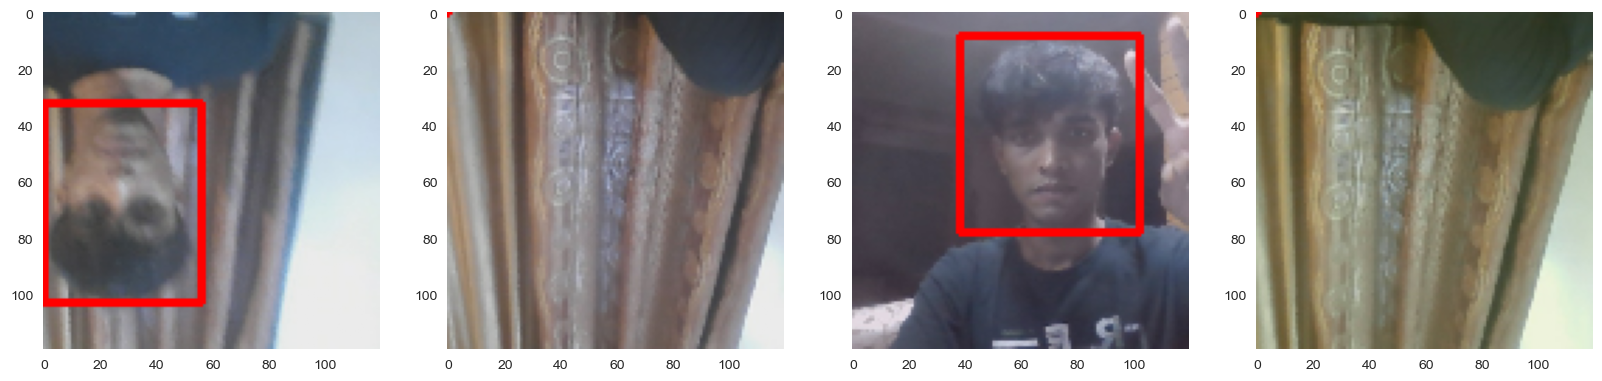

In [144]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
    ax[idx].grid(False)

### Building Deep Learning Model using Functional API

In [145]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [147]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 12s 0us/step


In [148]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [150]:
 def build_model():
        input_layer = Input(shape=(120,120,3))
        vgg = VGG16(include_top=False)(input_layer)
        
        f1=GlobalMaxPooling2D()(vgg)
        class1 = Dense(2048,activation = 'relu')(f1)
        class2 = Dense(1, activation='sigmoid')(class1)
        
        f2 = GlobalMaxPooling2D()(vgg)
        regress1 = Dense(2048,activation='relu')(f2)
        regress2 = Dense(4, activation='sigmoid')(regress1)
        
        facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
        return facetracker

### Testing out out Neural Netork without Training the model

In [151]:
facetracker = build_model()

In [152]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [153]:
X, y = train.as_numpy_iterator().next()

In [172]:
X.shape

(8, 120, 120, 3)

In [173]:
classes , coords = facetracker.predict(X)

1/1 [==============================] - 1s 777ms/step


In [174]:
classes , coords

(array([[0.41335186],
        [0.43252662],
        [0.44040367],
        [0.39340428],
        [0.37812567],
        [0.39498782],
        [0.3863027 ],
        [0.47834703]], dtype=float32),
 array([[0.3751166 , 0.6311186 , 0.5343852 , 0.54566145],
        [0.3132846 , 0.64374936, 0.48524454, 0.53762877],
        [0.331367  , 0.6160292 , 0.5049238 , 0.5497775 ],
        [0.3551841 , 0.5966556 , 0.4377471 , 0.57896394],
        [0.38988522, 0.6105012 , 0.53901386, 0.57338035],
        [0.36840463, 0.57703596, 0.50890404, 0.5656588 ],
        [0.3446079 , 0.6551983 , 0.45743245, 0.5401945 ],
        [0.3565664 , 0.65186733, 0.46603036, 0.500208  ]], dtype=float32))

### Defining the loss function

In [154]:
len(train)

420

In [158]:
batches_per_epoch = 420
lr_decay = (1./0.75-1)/batches_per_epoch

In [161]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [167]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [168]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [178]:
classloss(y[0], classes).numpy()

0.88306606

In [177]:
localization_loss(y[1], coords).numpy()

8.110666

### Training Neural Network using Custom Model Class

In [179]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [181]:
model = FaceTracker(facetracker)

In [183]:
model.compile(opt, classloss, regressloss)

#### Training the data

In [184]:
logdir = 'logs'

In [185]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [216]:
hist = model.fit( train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
420/420 [==============================] - 563s 1s/step - total_loss: 0.0032 - class_loss: 8.8752e-06 - regress_loss: 0.0032 - val_total_loss: 0.5199 - val_class_loss: 8.0042e-04 - val_regress_loss: 0.5195
Epoch 2/5
420/420 [==============================] - 573s 1s/step - total_loss: 0.0028 - class_loss: 8.5300e-06 - regress_loss: 0.0028 - val_total_loss: 0.1357 - val_class_loss: 2.4834e-05 - val_regress_loss: 0.1357
Epoch 3/5
420/420 [==============================] - 607s 1s/step - total_loss: 0.0030 - class_loss: 6.3454e-06 - regress_loss: 0.0030 - val_total_loss: 0.0910 - val_class_loss: 1.3993e-05 - val_regress_loss: 0.0910
Epoch 4/5
420/420 [==============================] - 547s 1s/step - total_loss: 0.0031 - class_loss: 6.8293e-06 - regress_loss: 0.0031 - val_total_loss: 1.1124 - val_class_loss: 0.0044 - val_regress_loss: 1.1102
Epoch 5/5
420/420 [==============================] - 535s 1s/step - total_loss: 0.0026 - class_loss: 5.3244e-06 - regress_loss: 0.0026 - val

In [217]:
hist.history

{'total_loss': [0.0037659460213035345,
  0.0029919547960162163,
  0.0014331203419715166,
  0.002063036896288395,
  0.0007504451787099242],
 'class_loss': [1.3426184523268603e-05,
  7.063324574119179e-06,
  6.9291027102735825e-06,
  2.7269347810943145e-06,
  2.689683242351748e-06],
 'regress_loss': [0.0037592328153550625,
  0.0029884232208132744,
  0.001429655821993947,
  0.002061673440039158,
  0.0007491003489121795],
 'val_total_loss': [0.5199114084243774,
  0.1357462853193283,
  0.09097891300916672,
  1.112438678741455,
  0.37959155440330505],
 'val_class_loss': [0.0008004208793863654,
  2.4833931092871353e-05,
  1.3992917047289666e-05,
  0.0043938541784882545,
  0.0004689235065598041],
 'val_regress_loss': [0.5195112228393555,
  0.13573387265205383,
  0.0909719169139862,
  1.1102417707443237,
  0.37935709953308105]}

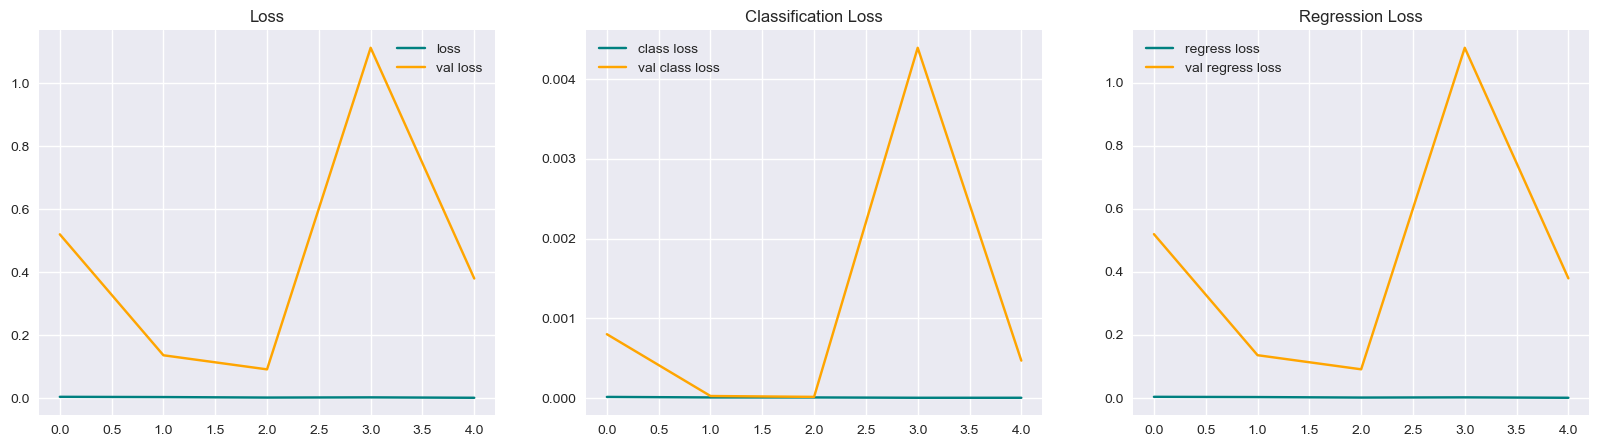

In [218]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [219]:
test_data = test.as_numpy_iterator()

In [226]:
test_sample = test_data.next()

In [227]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 249ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


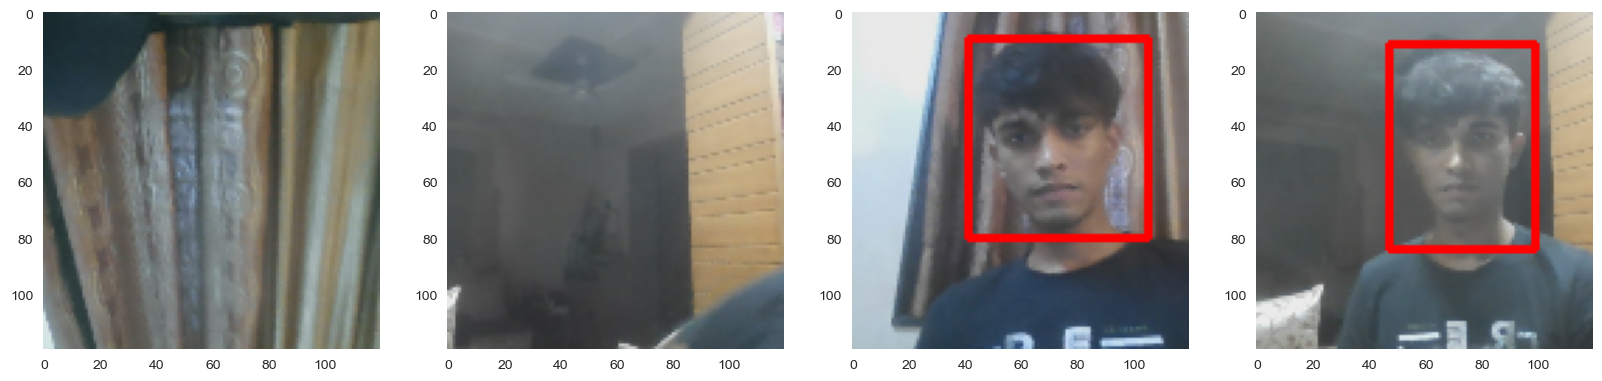

In [228]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)
    ax[idx].grid(False)

In [209]:
from tensorflow.keras.models import load_model

In [210]:
facetracker.save('facetracker.h5')

In [211]:
facetracker = load_model('facetracker.h5')

### Real Time Detection

In [2]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined